# Clone official repo

In [1]:
! git clone https://github.com/xuebinqin/DIS

%cd ./DIS/IS-Net

!pip install gdown

Cloning into 'DIS'...
remote: Enumerating objects: 355, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 355 (delta 96), reused 85 (delta 76), pack-reused 234
Receiving objects: 100% (355/355), 49.60 MiB | 27.31 MiB/s, done.
Resolving deltas: 100% (172/172), done.
/content/DIS/IS-Net


In [2]:
!mkdir ./saved_models

# Imports

In [3]:
import numpy as np
from PIL import Image
import torch
from torch.autograd import Variable
from torchvision import transforms
import torch.nn.functional as F
import gdown
import os

import requests
import matplotlib.pyplot as plt
from io import BytesIO

# project imports
from data_loader_cache import normalize, im_reader, im_preprocess
from models import *


/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


# Helpers

In [4]:
drive_link = "https://drive.google.com/uc?id=1XHIzgTzY5BQHw140EDIgwIb53K659ENH"

# Specify the local path and filename
local_path = "/content/DIS/IS-Net/saved_models/isnet.pth"

# Download the file
gdown.download(drive_link, local_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1XHIzgTzY5BQHw140EDIgwIb53K659ENH
To: /content/DIS/IS-Net/saved_models/isnet.pth
100%|██████████| 177M/177M [00:03<00:00, 57.9MB/s]


'/content/DIS/IS-Net/saved_models/isnet.pth'

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Download official weights



class GOSNormalize(object):
    '''
    Normalize the Image using torch.transforms
    '''
    def __init__(self, mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]):
        self.mean = mean
        self.std = std

    def __call__(self,image):
        image = normalize(image,self.mean,self.std)
        return image


transform =  transforms.Compose([GOSNormalize([0.5,0.5,0.5],[1.0,1.0,1.0])])

def load_image(im_path, hypar):
    if im_path.startswith("http"):
        im_path = BytesIO(requests.get(im_path).content)

    im = im_reader(im_path)
    im, im_shp = im_preprocess(im, hypar["cache_size"])
    im = torch.divide(im,255.0)
    shape = torch.from_numpy(np.array(im_shp))
    return transform(im).unsqueeze(0), shape.unsqueeze(0) # make a batch of image, shape


def build_model(hypar,device):
    net = hypar["model"]#GOSNETINC(3,1)

    # convert to half precision
    if(hypar["model_digit"]=="half"):
        net.half()
        for layer in net.modules():
            if isinstance(layer, nn.BatchNorm2d):
                layer.float()

    net.to(device)

    if(hypar["restore_model"]!=""):
        net.load_state_dict(torch.load(hypar["model_path"]+"/"+hypar["restore_model"],map_location=device))
        net.to(device)
    net.eval()
    return net


def predict(net,  inputs_val, shapes_val, hypar, device):
    '''
    Given an Image, predict the mask
    '''
    net.eval()

    if(hypar["model_digit"]=="full"):
        inputs_val = inputs_val.type(torch.FloatTensor)
    else:
        inputs_val = inputs_val.type(torch.HalfTensor)


    inputs_val_v = Variable(inputs_val, requires_grad=False).to(device) # wrap inputs in Variable

    ds_val = net(inputs_val_v)[0] # list of 6 results

    pred_val = ds_val[0][0,:,:,:] # B x 1 x H x W    # we want the first one which is the most accurate prediction

    ## recover the prediction spatial size to the orignal image size
    pred_val = torch.squeeze(F.upsample(torch.unsqueeze(pred_val,0),(shapes_val[0][0],shapes_val[0][1]),mode='bilinear'))

    ma = torch.max(pred_val)
    mi = torch.min(pred_val)
    pred_val = (pred_val-mi)/(ma-mi) # max = 1

    if device == 'cuda': torch.cuda.empty_cache()
    return (pred_val.detach().cpu().numpy()*255).astype(np.uint8) # it is the mask we need

# Set Parameters

In [6]:
hypar = {} # paramters for inferencing


hypar["model_path"] ="./saved_models" ## load trained weights from this path
hypar["restore_model"] = "isnet.pth" ## name of the to-be-loaded weights
hypar["interm_sup"] = False ## indicate if activate intermediate feature supervision

##  choose floating point accuracy --
hypar["model_digit"] = "full" ## indicates "half" or "full" accuracy of float number
hypar["seed"] = 0

hypar["cache_size"] = [1024, 1024] ## cached input spatial resolution, can be configured into different size

## data augmentation parameters ---
hypar["input_size"] = [1024, 1024] ## mdoel input spatial size, usually use the same value hypar["cache_size"], which means we don't further resize the images
hypar["crop_size"] = [1024, 1024] ## random crop size from the input, it is usually set as smaller than hypar["cache_size"], e.g., [920,920] for data augmentation

hypar["model"] = ISNetDIS()

# Build Model

In [7]:
net = build_model(hypar, device)

# Predict Mask

In [8]:
gsheetid = "1n9kk7IHyBzkw5e08wpjjt-Ry5aE_thqGrJ97rMeN-K4"
sheet_name = "sarvm"

In [9]:
gsheet_url = "https://docs.google.com/spreadsheets/d/{}/gviz/tq?tqx=out:csv&sheet={}".format(gsheetid, sheet_name)

In [10]:
gsheet_url

'https://docs.google.com/spreadsheets/d/1n9kk7IHyBzkw5e08wpjjt-Ry5aE_thqGrJ97rMeN-K4/gviz/tq?tqx=out:csv&sheet=sarvm'

In [11]:
import pandas as pd
df = pd.read_csv(gsheet_url)

In [13]:
image_path = df.iloc[-1]['Image']

In [15]:
drive_link = "https://drive.google.com/uc?id=132iFIWDU6NSzZy4oEUurGplQ2Z3tGGKb"

# Specify the local path and filename
local_path = "/content/DIS/IS-Net/saved_models/input2.jpg"

# Download the file
gdown.download(drive_link, local_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=132iFIWDU6NSzZy4oEUurGplQ2Z3tGGKb
To: /content/DIS/IS-Net/saved_models/input2.jpg
100%|██████████| 27.7k/27.7k [00:00<00:00, 42.7MB/s]


'/content/DIS/IS-Net/saved_models/input2.jpg'

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


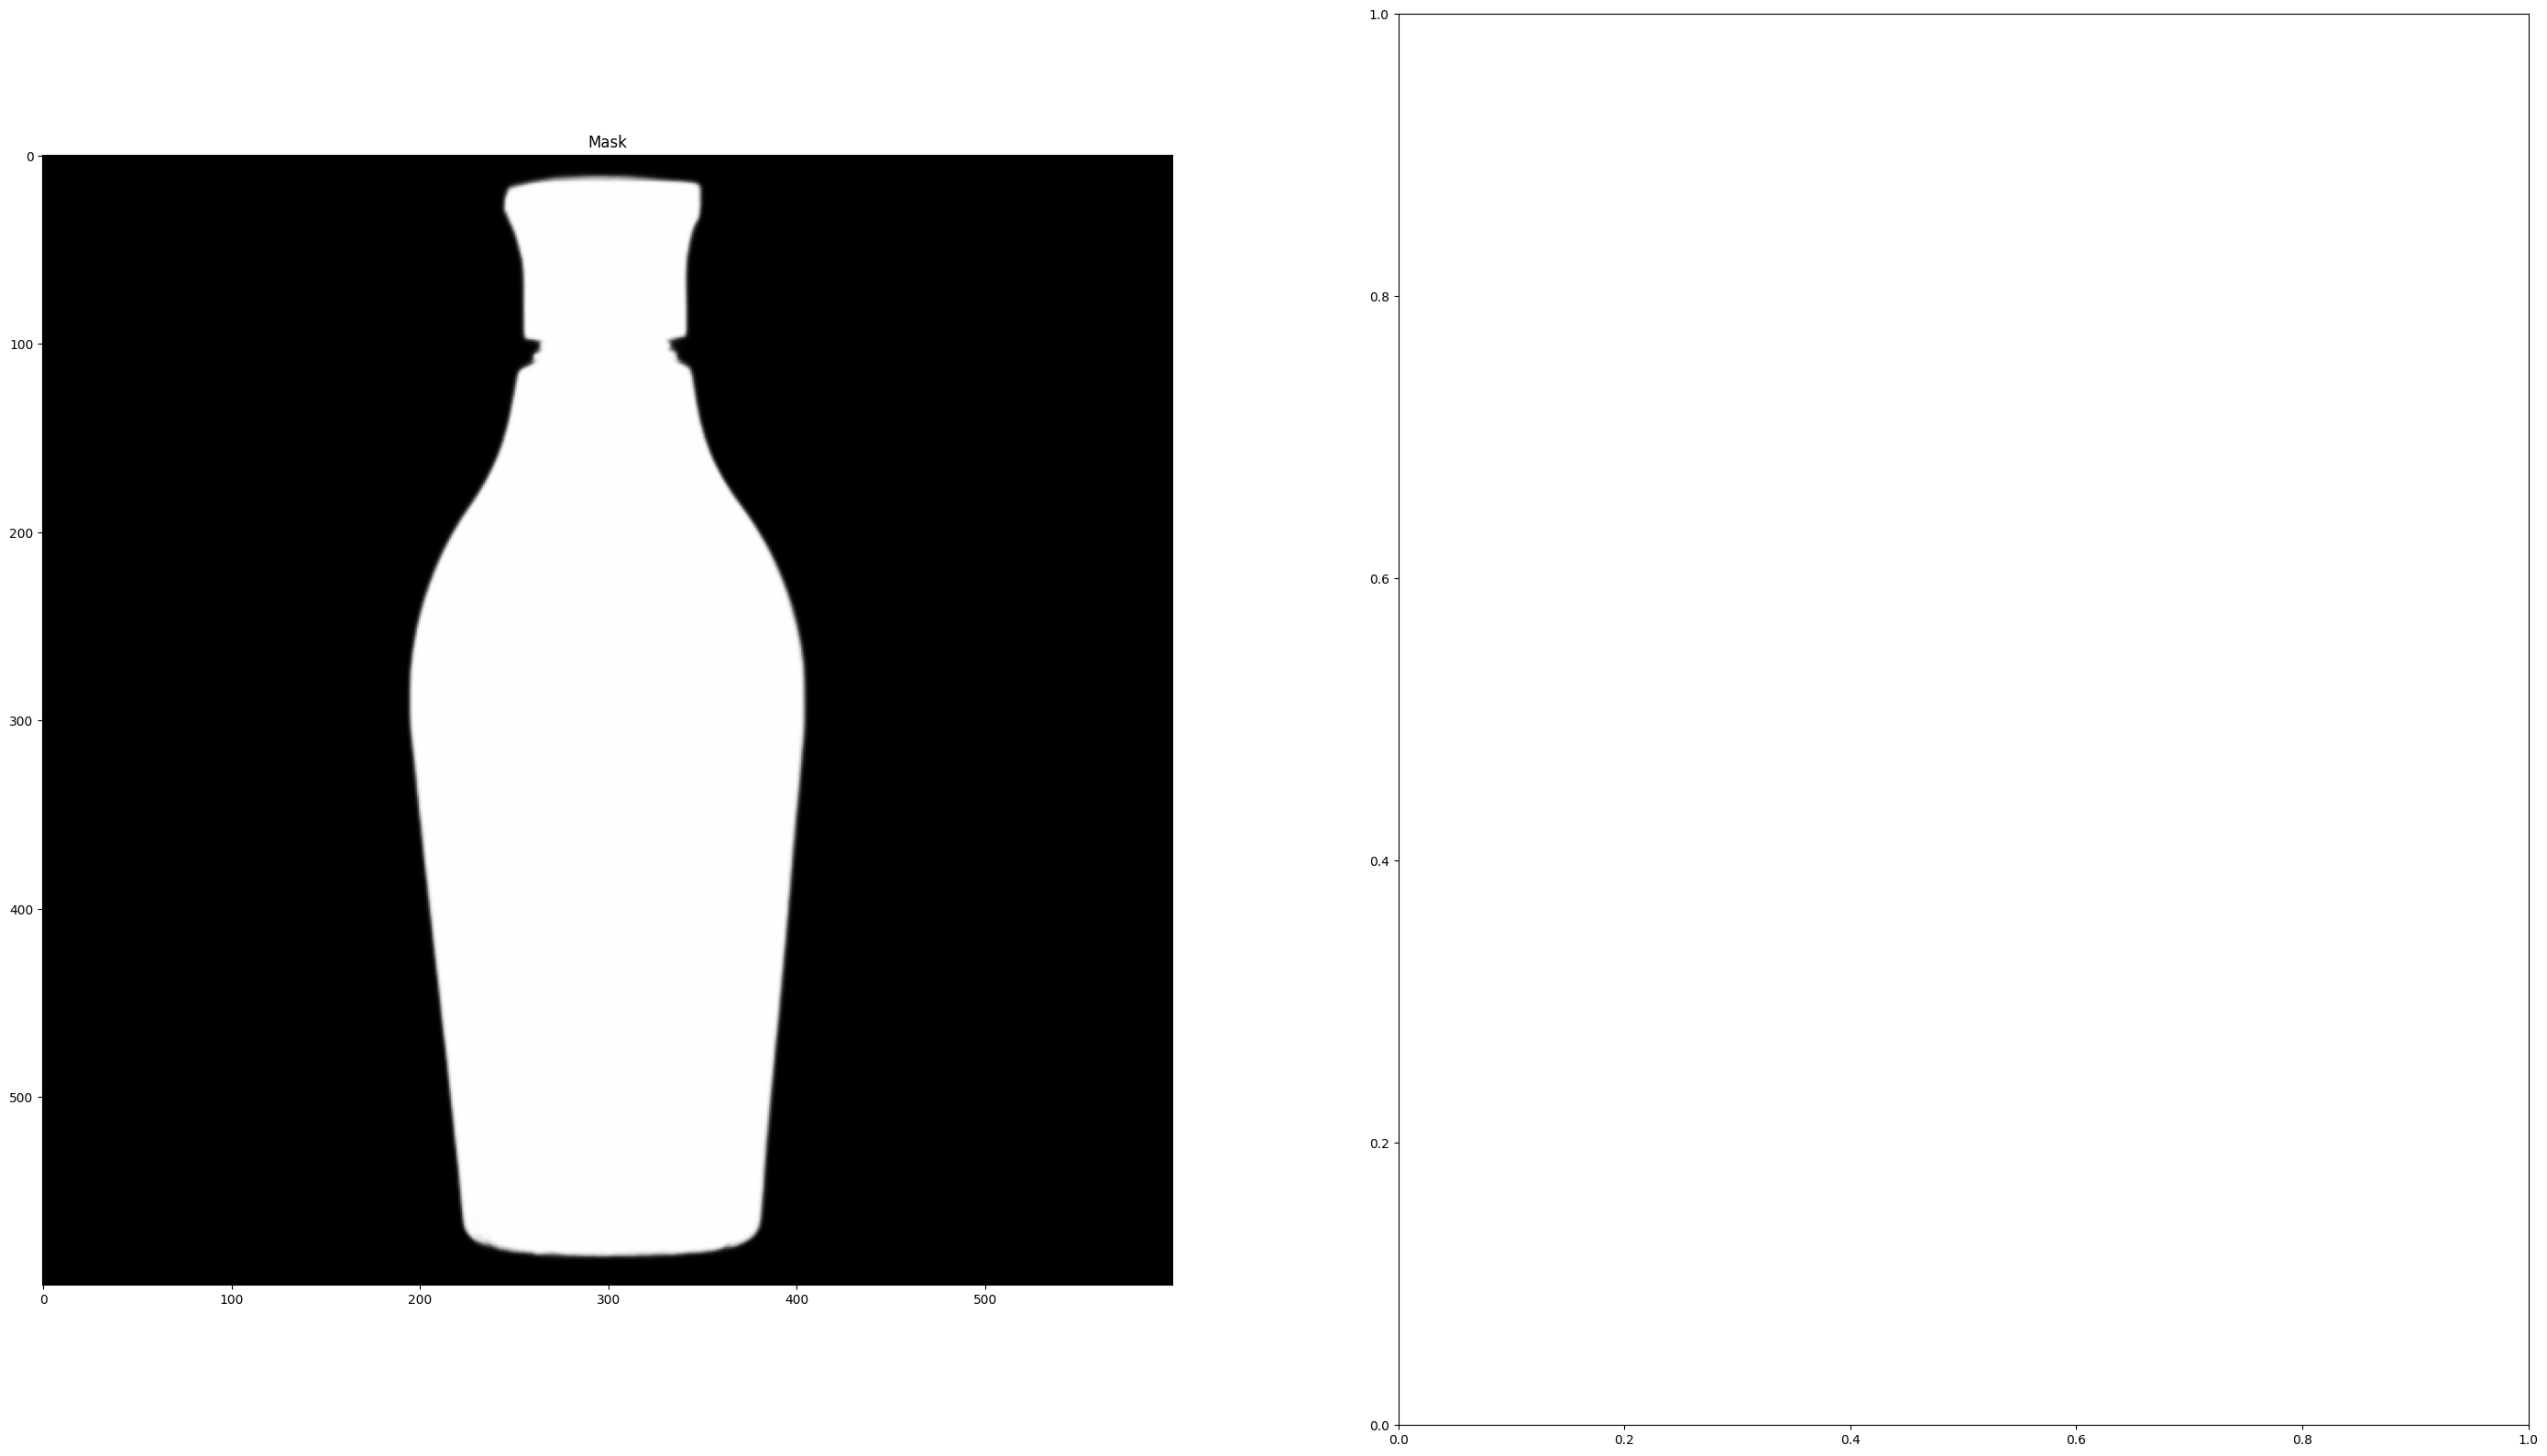

In [17]:
from google.colab.patches import cv2_imshow
from PIL import Image
image_path = "/content/DIS/IS-Net/saved_models/input2.jpg"
# image_bytes = BytesIO(requests.get(image_path).content)
# print(image_bytes)
image_tensor, orig_size = load_image(image_path, hypar)
mask = predict(net,image_tensor,orig_size, hypar, device)
image = Image.open(image_path)

f, ax = plt.subplots(1,2, figsize = (35,20))

# ax[0].imshow(np.array(Image.open(image_bytes))) # Original image
# cv2_imshow(image_path)

ax[0].imshow(mask, cmap = 'gray') # retouched image

# ax[0].set_title("Original Image")
ax[0].set_title("Mask")

plt.show()

In [18]:
import cv2
image = cv2.imread(image_path)
h, w , _ = image.shape
# print(h)
# print(w)
# print(_)
# print(image)
h, w , _ = image.shape
# print(h)
# print(w)
# print(_)
# new_image = np.zeros_like(image)
# new_image[mask] = image[mask]
new_image = cv2.bitwise_and(image, image, mask=mask)
transparent_bg = np.zeros((new_image.shape[0],new_image.shape[1], new_image.shape[2]+1) , dtype=np.uint8)

# Apply the mask to the transparent background
transparent_bg[:, :, :3] = new_image

# Set the alpha channel using the mask
transparent_bg[:, :, 3] = mask

# Save the new image with a transparent background
output_path = "/content/output.png"
cv2.imwrite(output_path, transparent_bg)
# Save the new image
# output_path = "/content/output.jpg"
# cv2.imwrite(output_path, new_image)

True